In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outfigdir  = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/"

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass'].isin(['L5IT', 'L6IT'])]
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

View of AnnData object with n_obs × n_vars = 4906 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_54804/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,Subclass,cond,easitype,umap1,umap2,easisample,easicond,newtype
AAACGCTCACTTCATT-1-P8_1a-P8,Excitatory,False,0.025713,1,0,23384.0,4943,0.000128,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGATAGGTGCATG-1-P8_1a-P8,Excitatory,False,0.011883,1,0,17774.0,4698,0.000169,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGGCCAGTATACC-1-P8_1a-P8,Excitatory,False,0.024667,1,0,15872.0,4173,0.000126,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCCATATACCG-1-P8_1a-P8,Excitatory,False,0.027921,1,0,20076.0,4761,0.000050,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCTCAGATGCT-1-P8_1a-P8,Excitatory,False,0.009527,1,4,19061.0,4601,0.000000,P8_1a,L2/3_BC,L2/3,P8NR,L2/3_C,NaN,NaN,1a,1-P08NR,L2/3_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTTGTTG-1-P38_dr_1a,NaN,False,0.042872,11,1,11379.0,3568,0.000879,P38_dr_1a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,1a,2-P38DR,L2/3_B
TTTGGTTTCTGCCTGT-1-P38_dr_2b,NaN,False,0.007108,2,1,16050.0,3104,0.000062,P38_dr_2b,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2b,2-P38DR,L2/3_B
TTTGTTGCACCGGTCA-1-P38_dr_2a,NaN,False,0.030928,2,1,13955.0,3739,0.001146,P38_dr_2a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2a,2-P38DR,L2/3_B
TTTGTTGGTGGCTAGA-1-P38_dr_2b,NaN,False,0.015884,3,4,7272.0,2789,0.000963,P38_dr_2b,L2/3_2,L2/3,P38DR,L2/3_B,NaN,NaN,2b,2-P38DR,L2/3_A


In [6]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

/tmp/ipykernel_54804/3478751590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [7]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values

rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

In [8]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [9]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [10]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# mean
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))

# organize
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

In [11]:
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

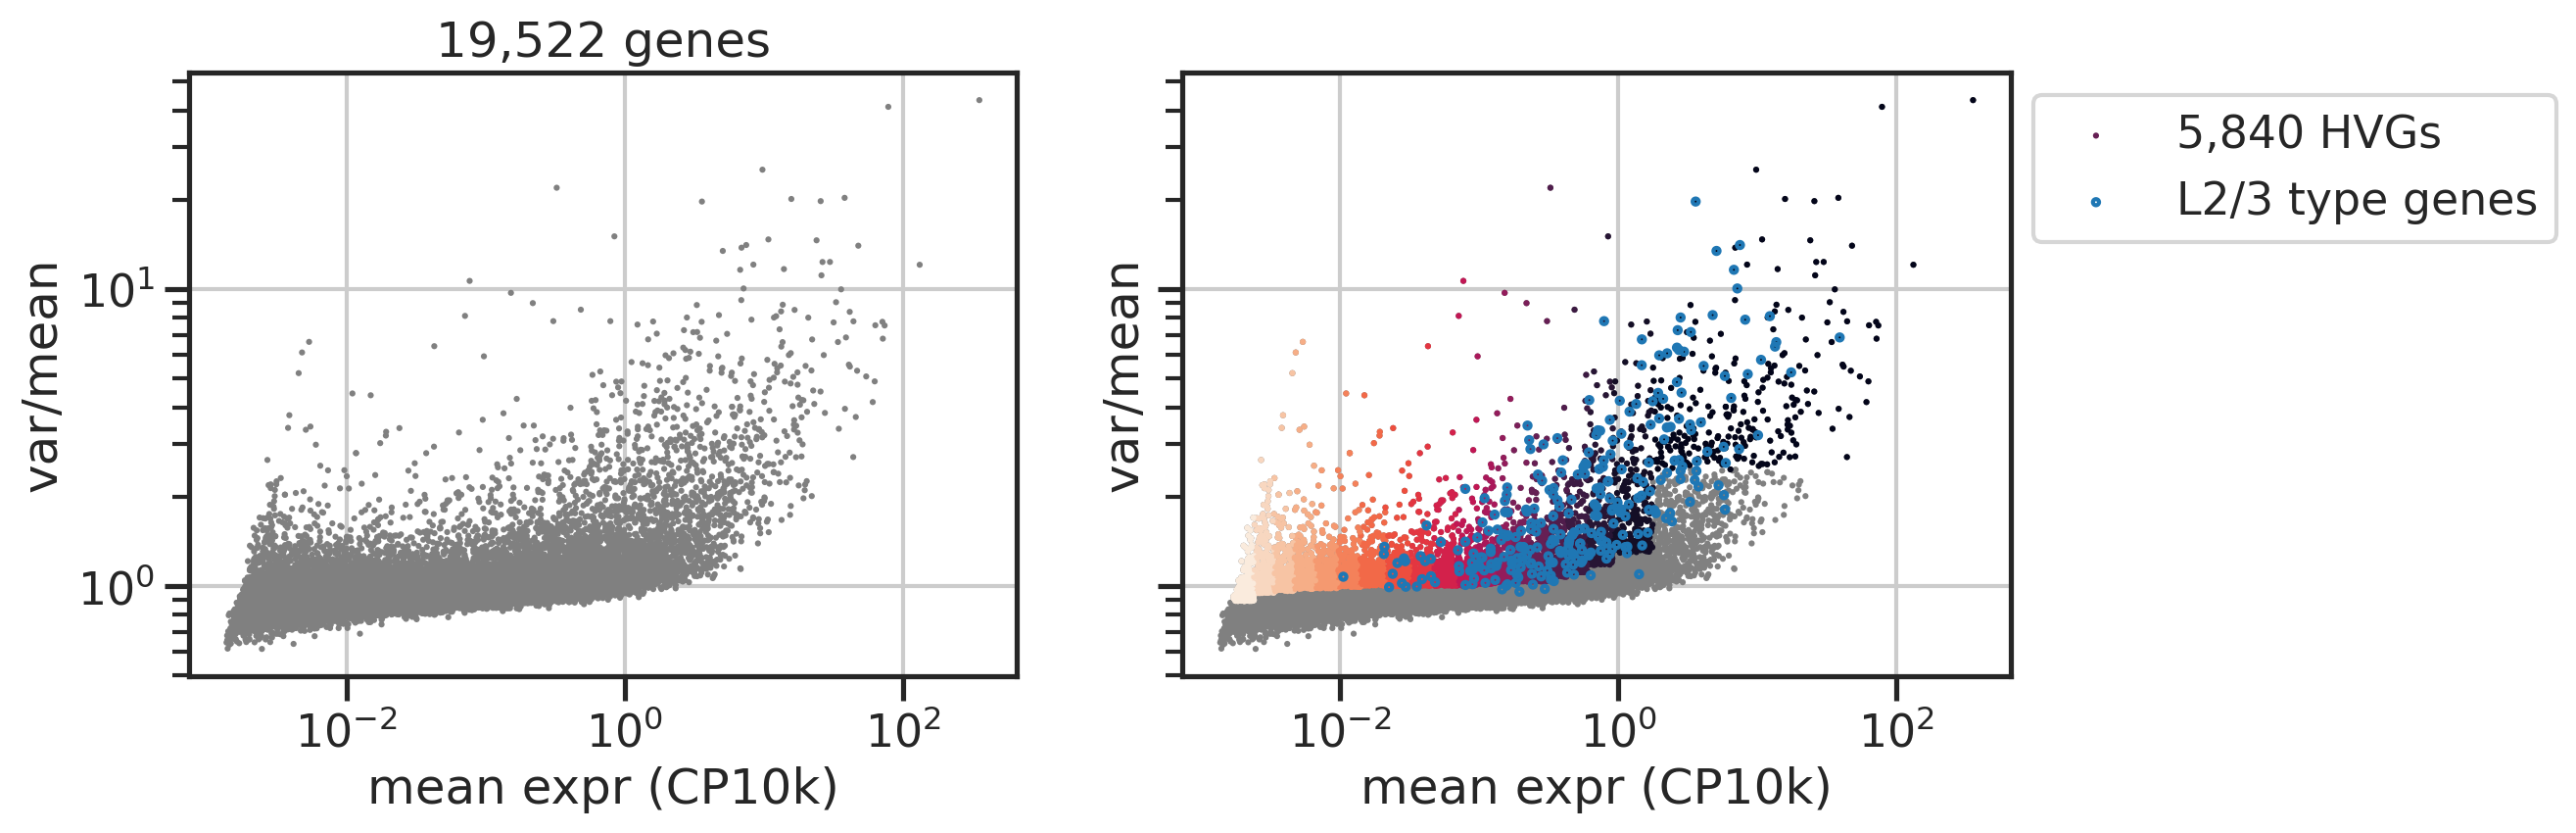

In [12]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.scatter(gm[l23_gidx], (gv/gm)[l23_gidx], s=5, facecolors='none', edgecolor='C0', label='L2/3 type genes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [13]:
adata = adata_sub[:,gsel_idx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 4906 × 5840
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [14]:
adata_nr = adata[adata.obs['cond']=='P28NR']
adata_dr = adata[adata.obs['cond']=='P28DR']
adata_nr, adata_dr

(View of AnnData object with n_obs × n_vars = 2285 × 5840
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
     layers: 'norm', 'lognorm',
 View of AnnData object with n_obs × n_vars = 2621 × 5840
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
     layers: 'norm', 'lognorm')

In [15]:
#
lognorm_nr = np.array(adata_nr.layers['lognorm'].todense())
zlognorm_nr = zscore(lognorm_nr, axis=0) # for each gene across cells
zlognorm_nr = np.nan_to_num(zlognorm_nr,0)

# 
lognorm_dr = np.array(adata_dr.layers['lognorm'].todense())
zlognorm_dr = zscore(lognorm_dr, axis=0) # for each gene across cells
zlognorm_dr = np.nan_to_num(zlognorm_dr,0)

In [16]:
lognorm_nr.shape

(2285, 5840)

In [17]:
%%time

np.random.seed(0)
pca_nr = PCA(n_components=50)
pcs_nr = pca_nr.fit_transform(zlognorm_nr)
# ucs_nr = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs_nr)
pca_dr = PCA(n_components=50)
pcs_dr = pca_dr.fit_transform(zlognorm_dr)


CPU times: user 14 s, sys: 16.2 s, total: 30.2 s
Wall time: 1.12 s


In [18]:
# get results
res_nr = adata_nr.obs.copy()
res_nr['biosamp'] = res_nr['sample'].apply(lambda x: x[:-1])
res_nr['type'] = res_nr['Type']
res_nr = res_nr.join(pd.DataFrame(pcs_nr, index=res_nr.index, columns=np.char.add("PC", ((1+np.arange(pcs_nr.shape[1])).astype(str)))))
# res_nr['umap1'] = ucs_nr[:,0]
# res_nr['umap2'] = ucs_nr[:,1]
res_nr

# get results
res_dr = adata_dr.obs.copy()
res_dr['biosamp'] = res_dr['sample'].apply(lambda x: x[:-1])
res_dr['type'] = res_dr['Type']
res_dr = res_dr.join(pd.DataFrame(pcs_dr, index=res_dr.index, columns=np.char.add("PC", ((1+np.arange(pcs_dr.shape[1])).astype(str)))))
# res_dr['umap1'] = ucs_dr[:,0]
# res_dr['umap2'] = ucs_dr[:,1]
res_dr

,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
AAACCCAAGCTCGACC-1-P28_dr_1b,NaN,False,0.040350,5,8,11145.0,3831,0.000538,P28_dr_1b,L5IT,...,-0.506646,-1.457290,-1.472371,-0.402250,-2.886943,-1.186373,0.025869,-0.161548,1.375649,-1.041535
AAACCCACAACTCGTA-1-P28_dr_3a,NaN,False,0.005291,5,8,11302.0,3839,0.000088,P28_dr_3a,L5IT,...,-1.368072,-3.290944,-0.227379,0.346150,-2.086689,-0.101085,1.563922,-1.285727,3.496079,2.303504
AAACCCACAGAGCGTA-1-P28_dr_1a,NaN,False,0.073892,5,8,13024.0,4584,0.004068,P28_dr_1a,L5IT,...,1.735133,-1.991157,-1.245679,-0.464702,-0.500791,0.768260,-0.319629,2.237127,0.113615,-0.099005
AAACCCAGTTATGTGC-1-P28_dr_3a,NaN,False,0.010133,7,5,13325.0,4012,0.000150,P28_dr_3a,L6IT_A,...,1.931992,-1.678953,0.422901,-2.525681,-0.535246,3.197438,2.204360,0.618960,-0.920447,1.026095
AAACGAAAGTTCGCAT-1-P28_dr_3a,NaN,False,0.032688,7,5,13708.0,3901,0.000584,P28_dr_3a,L6IT_A,...,0.776152,2.716468,-1.303528,0.410813,-1.046321,0.645287,-3.482961,0.688134,0.192341,-2.419734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAACGCCCA-1-P28_dr_1b,NaN,False,0.105861,5,8,15781.0,5036,0.005067,P28_dr_1b,L5IT,...,-0.414241,-0.998364,1.074020,-2.908543,2.643979,-0.300274,3.922490,1.147487,2.689021,2.828081
TTTGGTTCACATGACT-1-P28_dr_3b,NaN,False,0.021447,7,5,14405.0,3420,0.000972,P28_dr_3b,L6IT_A,...,1.700545,1.088335,1.251138,1.525553,0.694366,-0.676923,0.500524,-0.644723,1.052073,-0.260071
TTTGGTTGTACTCGCG-1-P28_dr_3b,NaN,False,0.016895,5,8,12943.0,3615,0.000464,P28_dr_3b,L5IT,...,2.084618,2.086659,0.867960,2.849666,-1.769449,3.241115,-3.064739,-0.118242,0.675515,-1.760253
TTTGGTTTCAGCCCAG-1-P28_dr_3a,NaN,False,0.030083,5,8,9542.0,3475,0.000210,P28_dr_3a,L5IT,...,0.347384,-5.062811,-2.760924,2.626652,-2.941594,-0.884360,2.664709,0.313037,1.865352,-1.277465


# correlate PCs

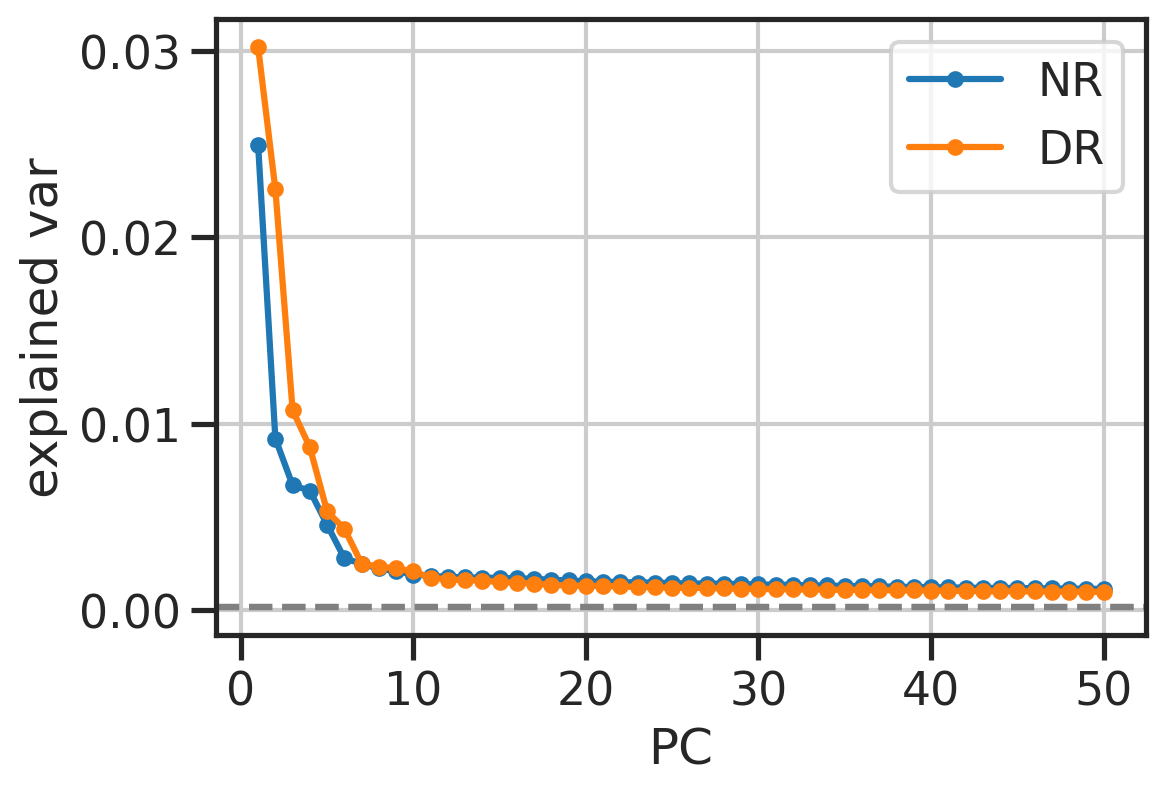

In [19]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca_nr.explained_variance_ratio_))+1, pca_nr.explained_variance_ratio_, '-o', markersize=5, label='NR')
ax.axhline(1/lognorm_nr.shape[1], linestyle='--', color='gray')

ax.plot(np.arange(len(pca_dr.explained_variance_ratio_))+1, pca_dr.explained_variance_ratio_, '-o', markersize=5, label='DR')
ax.axhline(1/lognorm_dr.shape[1], linestyle='--', color='gray')

ax.set_xlabel('PC')
ax.set_ylabel('explained var')
ax.legend()

In [20]:
vt_nr = pca_nr.components_
vt_dr = pca_dr.components_
vt_nr.shape, vt_dr.shape

((50, 5840), (50, 5840))

In [21]:
pcs_nr.shape

(2285, 50)

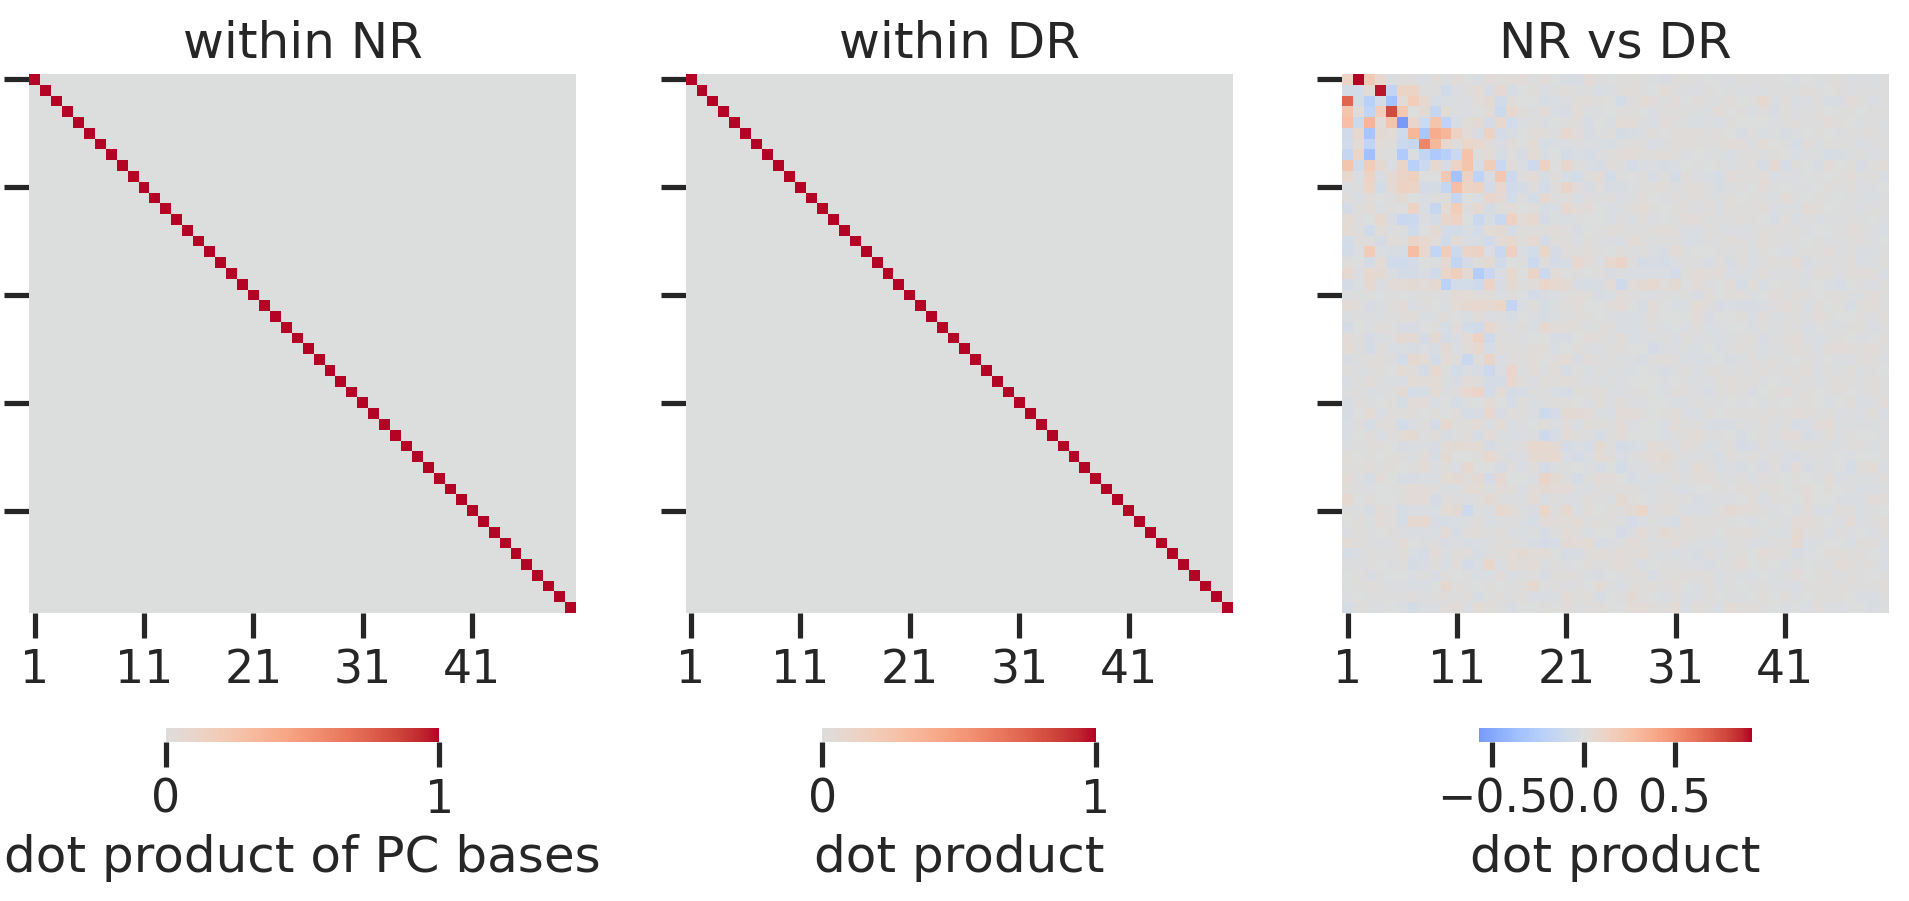

In [22]:
fig, axs = plt.subplots(1,3,figsize=(3*4,1*5), sharex=True, sharey=True)

ax = axs[0]
sns.heatmap(vt_nr.dot(vt_nr.T), cmap='coolwarm', center=0, ax=ax, 
            xticklabels=10,yticklabels=10, 
            cbar_kws=dict(location='bottom', shrink=0.5, label='dot product of PC bases'))
ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
ax.set_title('within NR')
ax = axs[1]
sns.heatmap(vt_dr.dot(vt_dr.T), cmap='coolwarm', center=0, ax=ax, 
            xticklabels=10,yticklabels=10, 
            cbar_kws=dict(location='bottom', shrink=0.5, label='dot product'))
ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
ax.set_title('within DR')
ax = axs[2]
sns.heatmap(vt_nr.dot(vt_dr.T), cmap='coolwarm', center=0, ax=ax, 
            xticklabels=10,yticklabels=10, 
            cbar_kws=dict(location='bottom', shrink=0.5, label='dot product'))
ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
ax.set_title('NR vs DR')
plt.show()

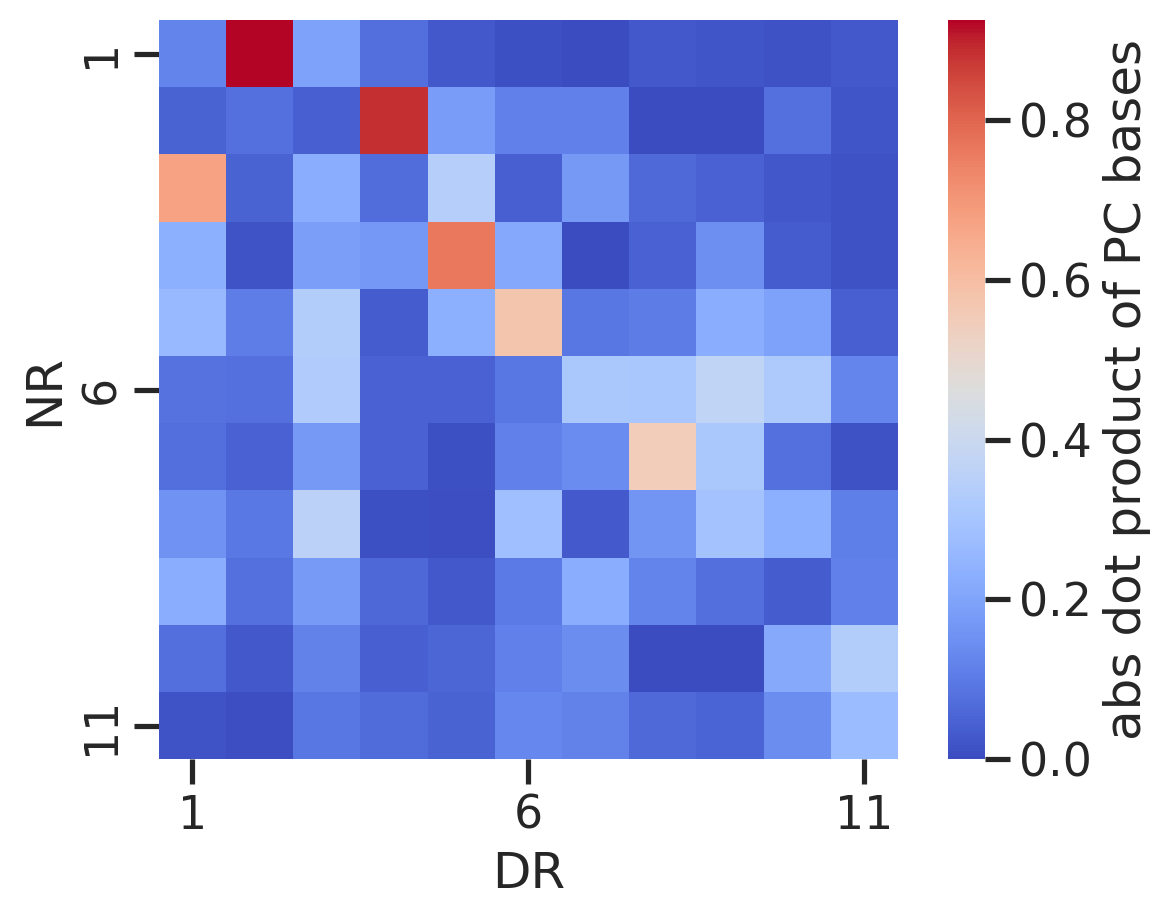

In [23]:
fig, ax = plt.subplots()
sns.heatmap(np.abs(vt_nr[:11].dot(vt_dr[:11].T)), 
            cmap='coolwarm', vmin=0, 
            xticklabels=5, yticklabels=5, 
            cbar_kws=dict(label='abs dot product of PC bases'),
            ax=ax,
           )
ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
ax.set_aspect('equal')
ax.set_ylabel('NR')
ax.set_xlabel('DR')
plt.show()

In [24]:
adata_nr = adata[adata.obs['cond']=='P28NR']
adata_nr1 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_1']
adata_nr1a = adata[adata.obs['sample']=='P28_1a']
adata_nr1b = adata[adata.obs['sample']=='P28_1b']
adata_nr2 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_2']

adata_dr = adata[adata.obs['cond']=='P28DR']
adata_dr1 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_dr_1']
adata_dr2 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_dr_3']

adata_nr, adata_dr, adata_nr1, adata_nr2, adata_dr1, adata_dr2

(View of AnnData object with n_obs × n_vars = 2285 × 5840
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
     layers: 'norm', 'lognorm',
 View of AnnData object with n_obs × n_vars = 2621 × 5840
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
     layers: 'norm', 'lognorm',
 View of AnnData object with n_obs × n_vars = 1057 × 5840
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
     layers: 'norm', 'lognorm',
 View of AnnData object with n_obs × n_vars = 1228 × 5840
     obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype',

In [25]:
def norm_pca(adata):
    
    np.random.seed(0)
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    pca = PCA(n_components=50)
    
    zlognorm = np.nan_to_num(zlognorm, 0)
    pcs = pca.fit_transform(zlognorm)
    return pca

In [26]:


vt_nr = norm_pca(adata_nr).components_
vt_dr = norm_pca(adata_dr).components_

vt_nr1 = norm_pca(adata_nr1).components_
vt_nr2 = norm_pca(adata_nr2).components_
vt_dr1 = norm_pca(adata_dr1).components_
vt_dr2 = norm_pca(adata_dr2).components_

vt_nr1a = norm_pca(adata_nr1a).components_
vt_nr1b = norm_pca(adata_nr1b).components_



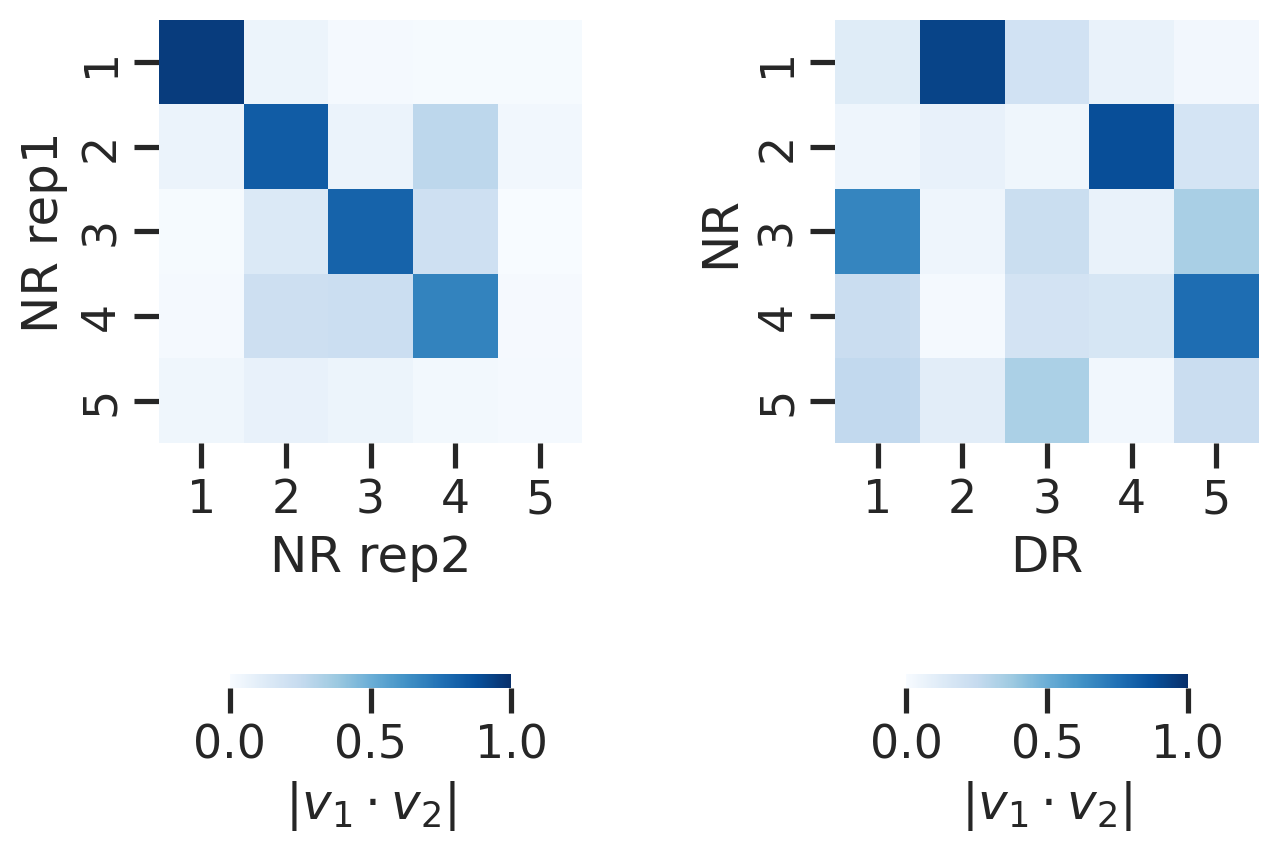

In [30]:
fig, axs = plt.subplots(1,2, figsize=(4*2,1*5))
cases = [
    ["NR rep1", "NR rep2", np.abs(vt_nr1[:5].dot(vt_nr2[:5].T))],
    ["NR", "DR", np.abs(vt_nr[:5].dot(vt_dr[:5].T))],
]
for case, ax in zip(cases, axs):
    ylbl, xlbl, mat = case
    sns.heatmap(mat, 
                cmap='Blues', vmin=0, vmax=1,
                xticklabels=1, yticklabels=1, 
                cbar_kws=dict(location='bottom', shrink=0.5, label=r'$|v_1 \cdot v_2|$', pad=0.3),
                ax=ax,
               )
    ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
    ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
    ax.set_aspect('equal')
    ax.set_ylabel(ylbl)
    ax.set_xlabel(xlbl)
output = os.path.join(outfigdir, 'pcdot_heatmap_l56.pdf')
powerplots.savefig(fig, output)
plt.show()

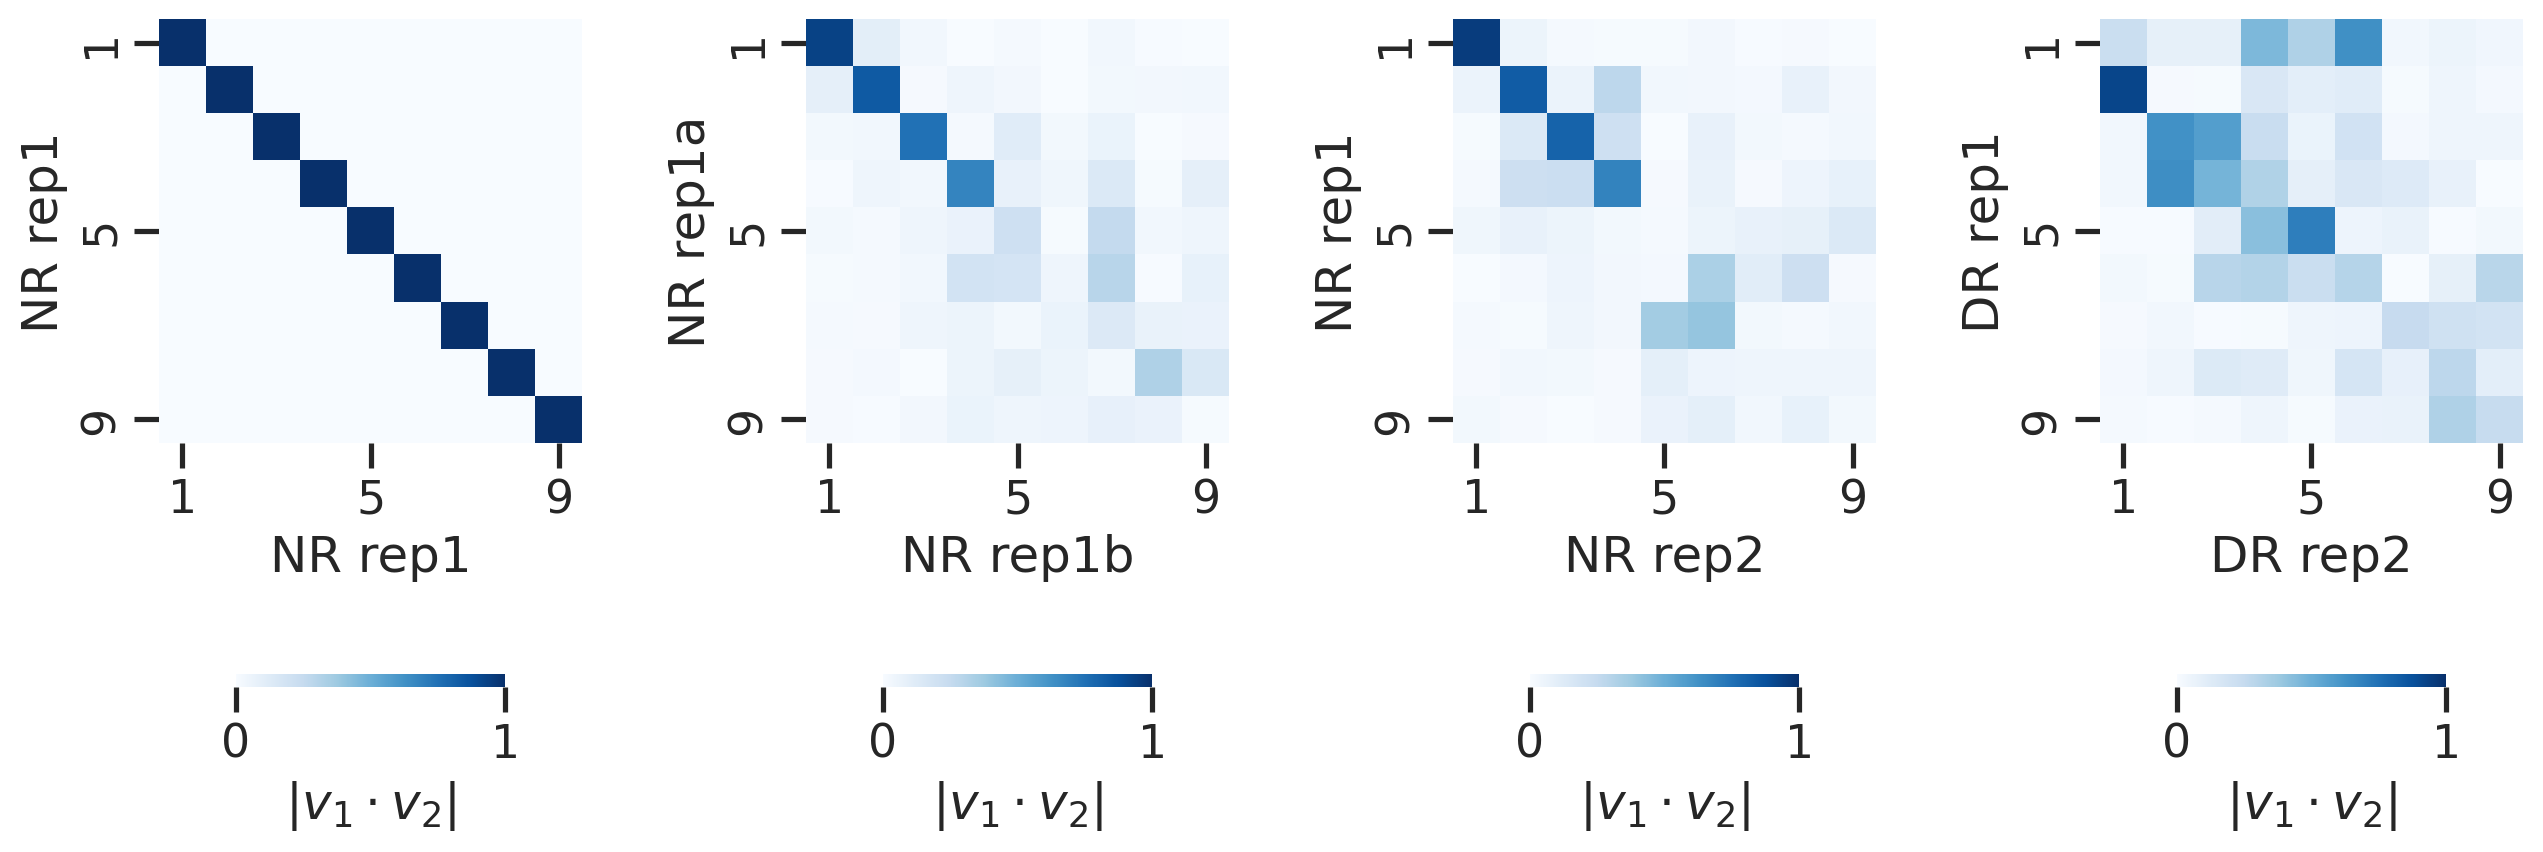

In [28]:
fig, axs = plt.subplots(1,4, figsize=(4*4,1*5))
cases = [
    ["NR rep1", "NR rep1", np.abs(vt_nr1[:9].dot(vt_nr1[:9].T))],
    ["NR rep1a", "NR rep1b", np.abs(vt_nr1a[:9].dot(vt_nr1b[:9].T))],
    ["NR rep1", "NR rep2", np.abs(vt_nr1[:9].dot(vt_nr2[:9].T))],
    ["DR rep1", "DR rep2", np.abs(vt_dr1[:9].dot(vt_dr2[:9].T))],
]
for case, ax in zip(cases, axs):
    ylbl, xlbl, mat = case
    sns.heatmap(mat, 
                cmap='Blues', vmin=0, vmax=1,
                xticklabels=4, yticklabels=4, 
                cbar_kws=dict(location='bottom', shrink=0.5, label=r'$|v_1 \cdot v_2|$', pad=0.3),
                ax=ax,
               )
    ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
    ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
    ax.set_aspect('equal')
    ax.set_ylabel(ylbl)
    ax.set_xlabel(xlbl)
plt.show()

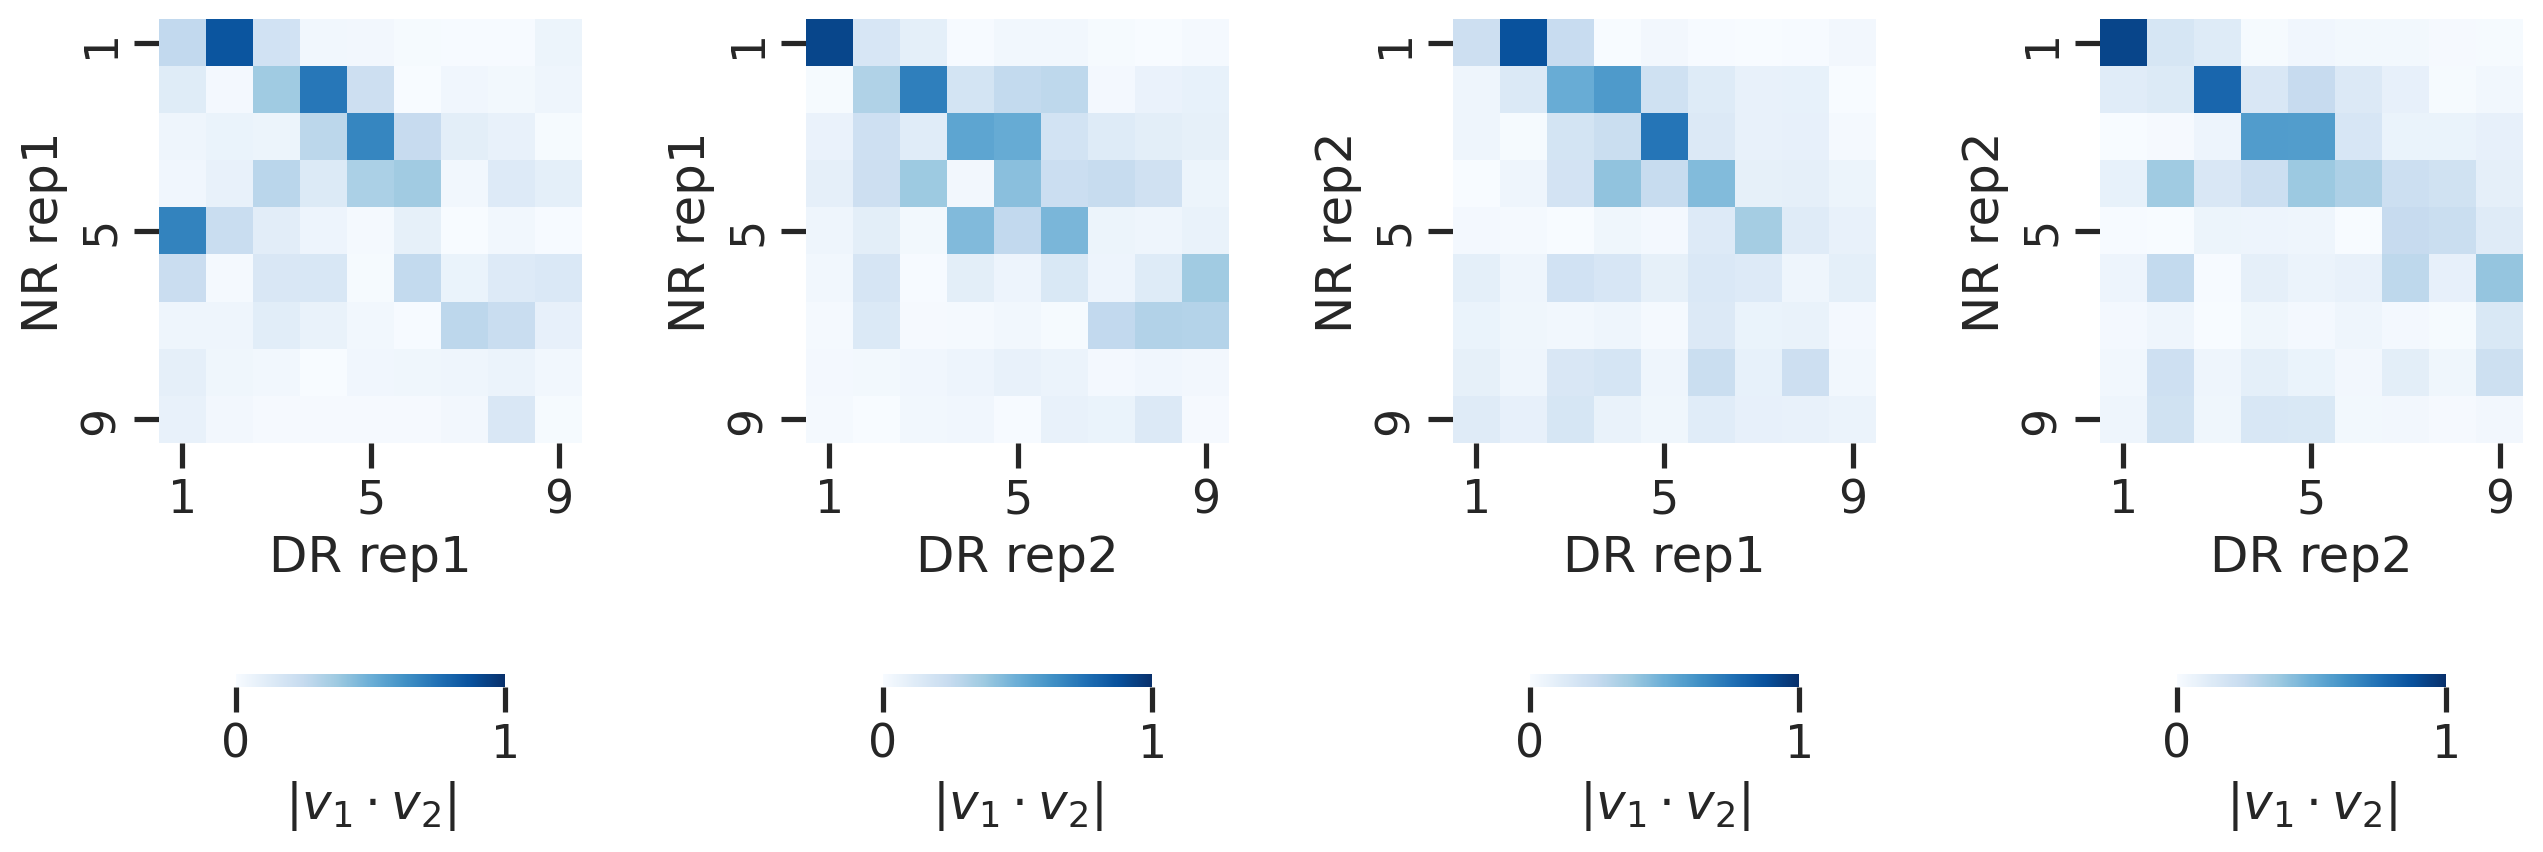

In [29]:
fig, axs = plt.subplots(1,4, figsize=(4*4,1*5))
cases = [
    ["NR rep1", "DR rep1", np.abs(vt_nr1[:9].dot(vt_dr1[:9].T))],
    ["NR rep1", "DR rep2", np.abs(vt_nr1[:9].dot(vt_dr2[:9].T))],
    ["NR rep2", "DR rep1", np.abs(vt_nr2[:9].dot(vt_dr1[:9].T))],
    ["NR rep2", "DR rep2", np.abs(vt_nr2[:9].dot(vt_dr2[:9].T))],
]
for case, ax in zip(cases, axs):
    ylbl, xlbl, mat = case
    sns.heatmap(mat, 
                cmap='Blues', vmin=0, vmax=1,
                xticklabels=4, yticklabels=4, 
                cbar_kws=dict(location='bottom', shrink=0.5, label=r'$|v_1 \cdot v_2|$', pad=0.3),
                ax=ax,
               )
    ax.set_xticklabels([int(i.get_text())+1 for i in ax.get_xticklabels()])
    ax.set_yticklabels([int(i.get_text())+1 for i in ax.get_yticklabels()])
    ax.set_aspect('equal')
    ax.set_ylabel(ylbl)
    ax.set_xlabel(xlbl)
plt.show()

In [24]:
colors = sns.color_palette('tab20', 10)
# 6-9
palette_biosamp = {
    'P28_1': colors[6],
    'P28_2': colors[7],
    
    'P28_dr_1': colors[8],
    'P28_dr_3': colors[9],
}
palette_cond = {
    'P28NR': colors[6],
    'P28DR': colors[8],
}

# # 0-5
# palette_type = {
#     'L2/3_A': colors[0],
#     'L2/3_B': colors[2],
#     'L2/3_C': colors[4],
    
#     'L2/3_1': colors[1],
#     'L2/3_2': colors[3],
#     'L2/3_3': colors[5],
# }
# palette_type_abc = {
#     'L2/3_A': colors[0],
#     'L2/3_B': colors[2],
#     'L2/3_C': colors[4],
    
#     'L2/3_1': 'lightgray',
#     'L2/3_2': 'lightgray',
#     'L2/3_3': 'lightgray',
# }
# colors

# NR

In [25]:
res = res_nr

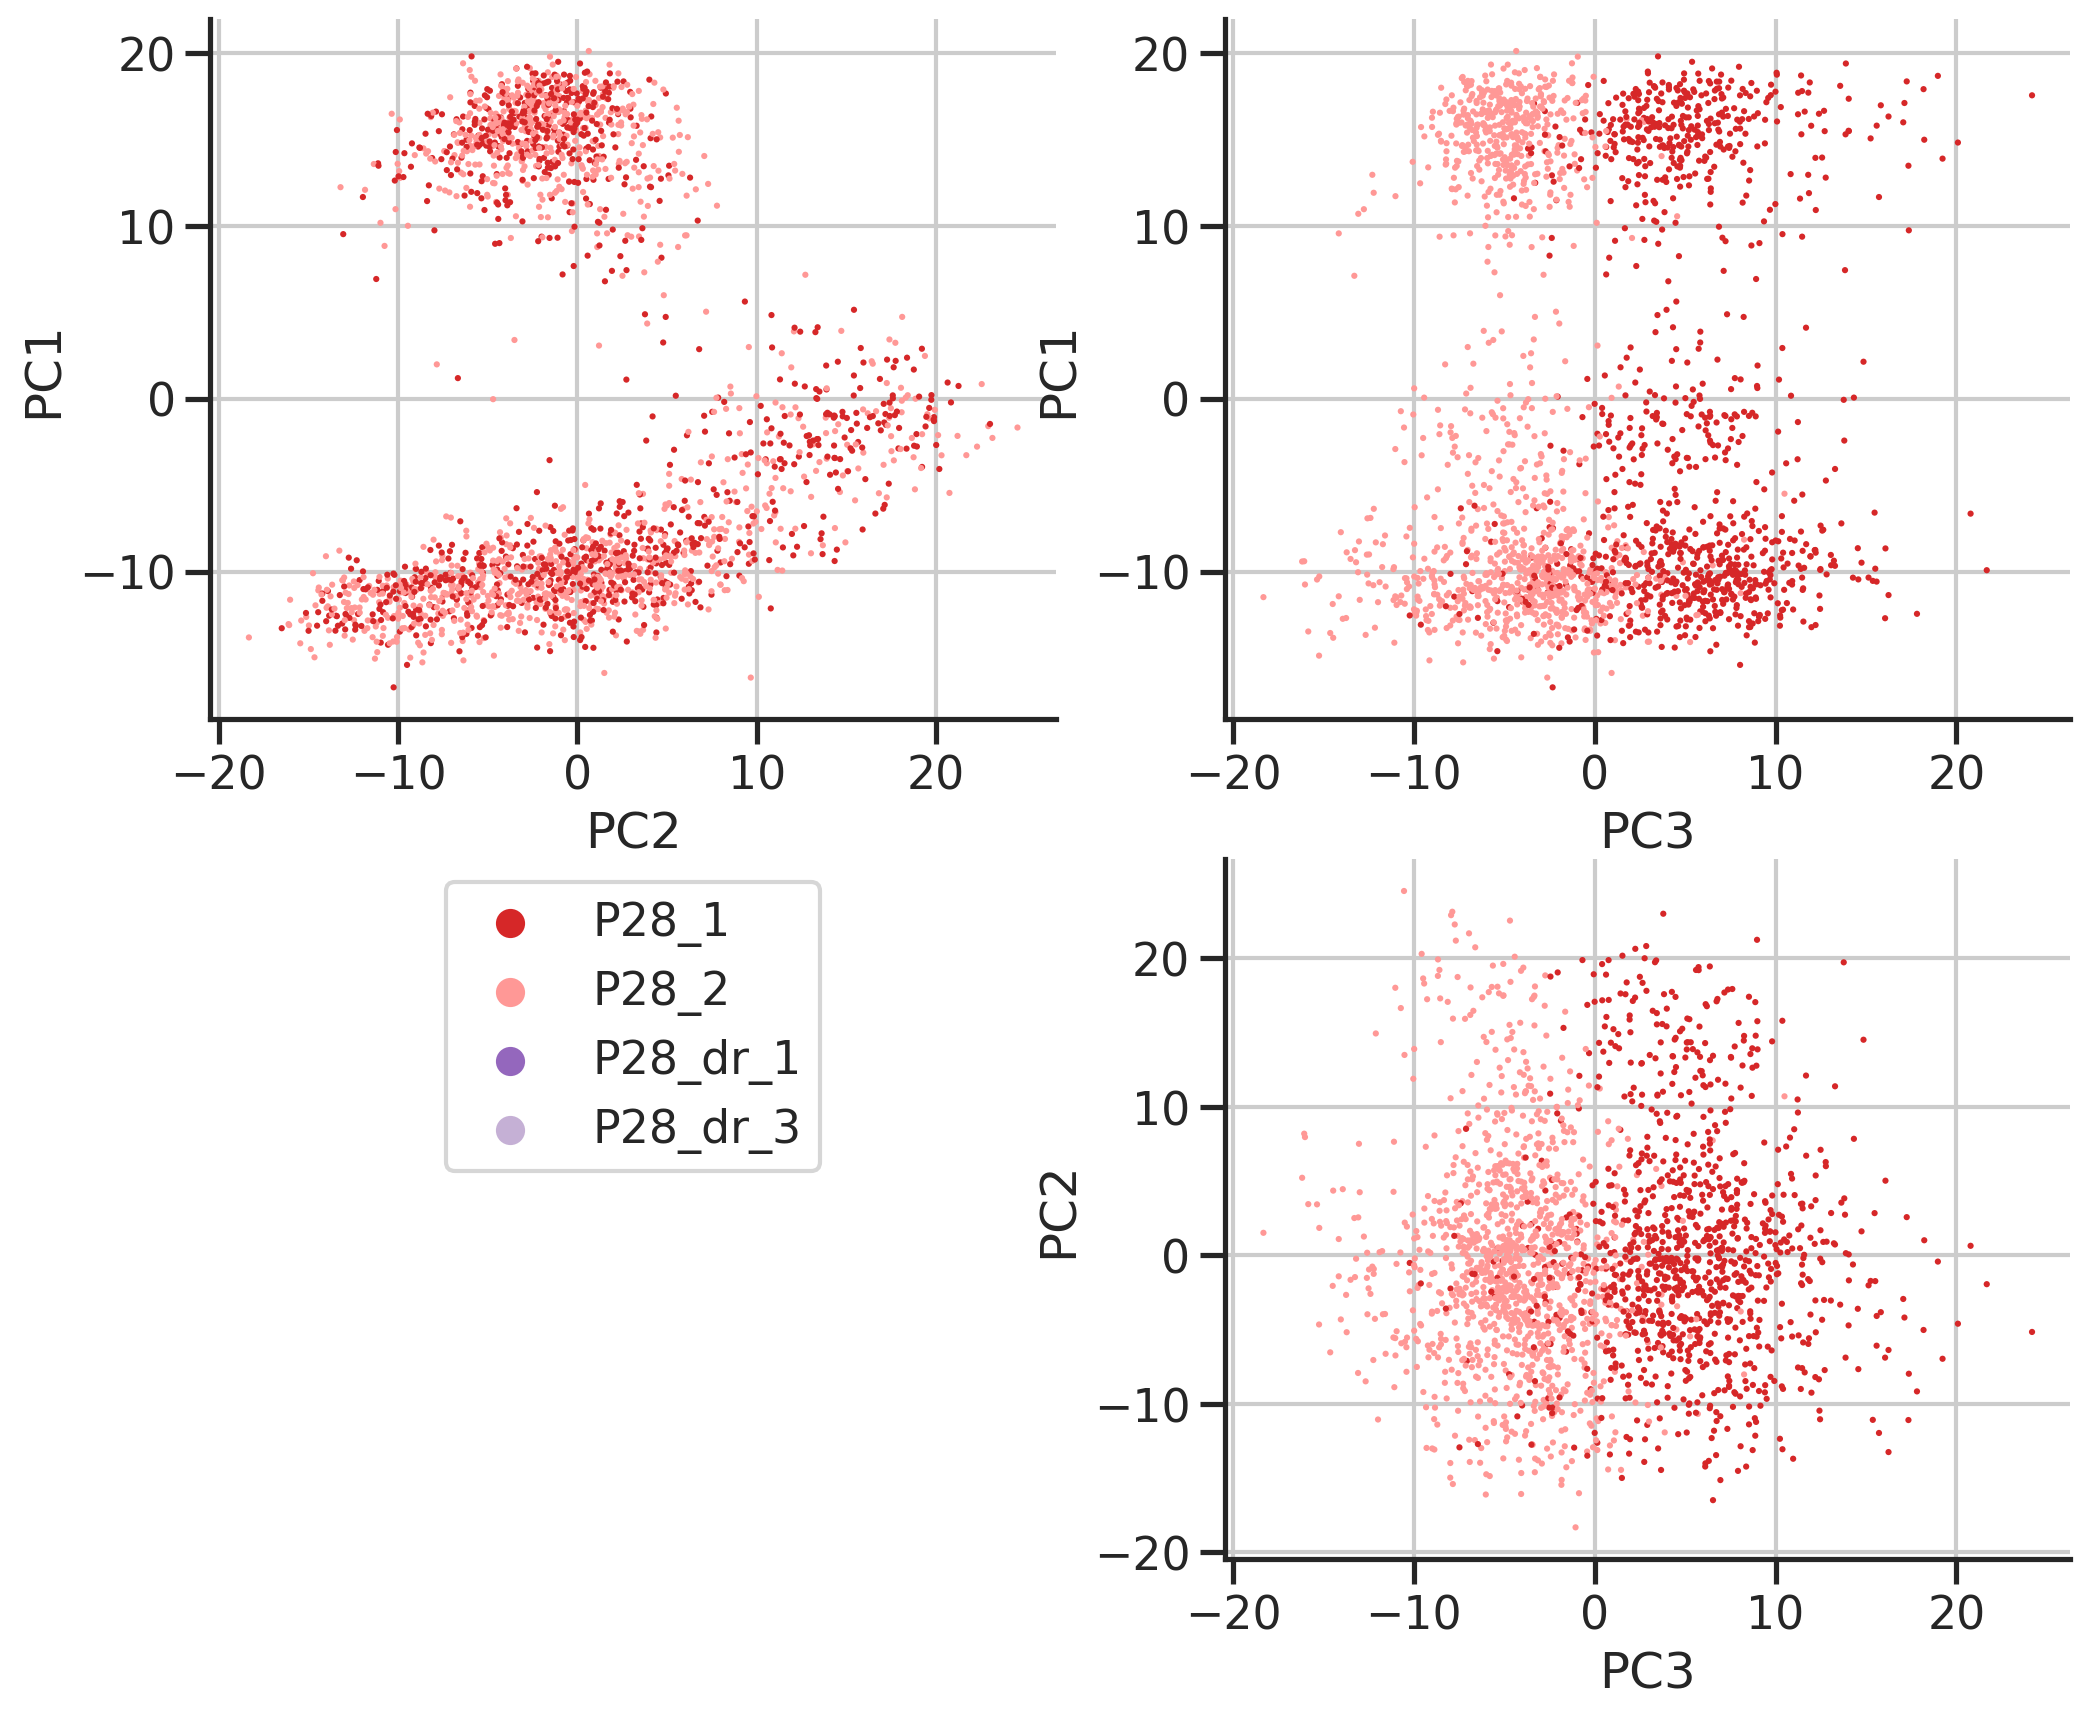

In [26]:
plot_pcs(res, 3, 'biosamp', palette=palette_biosamp)

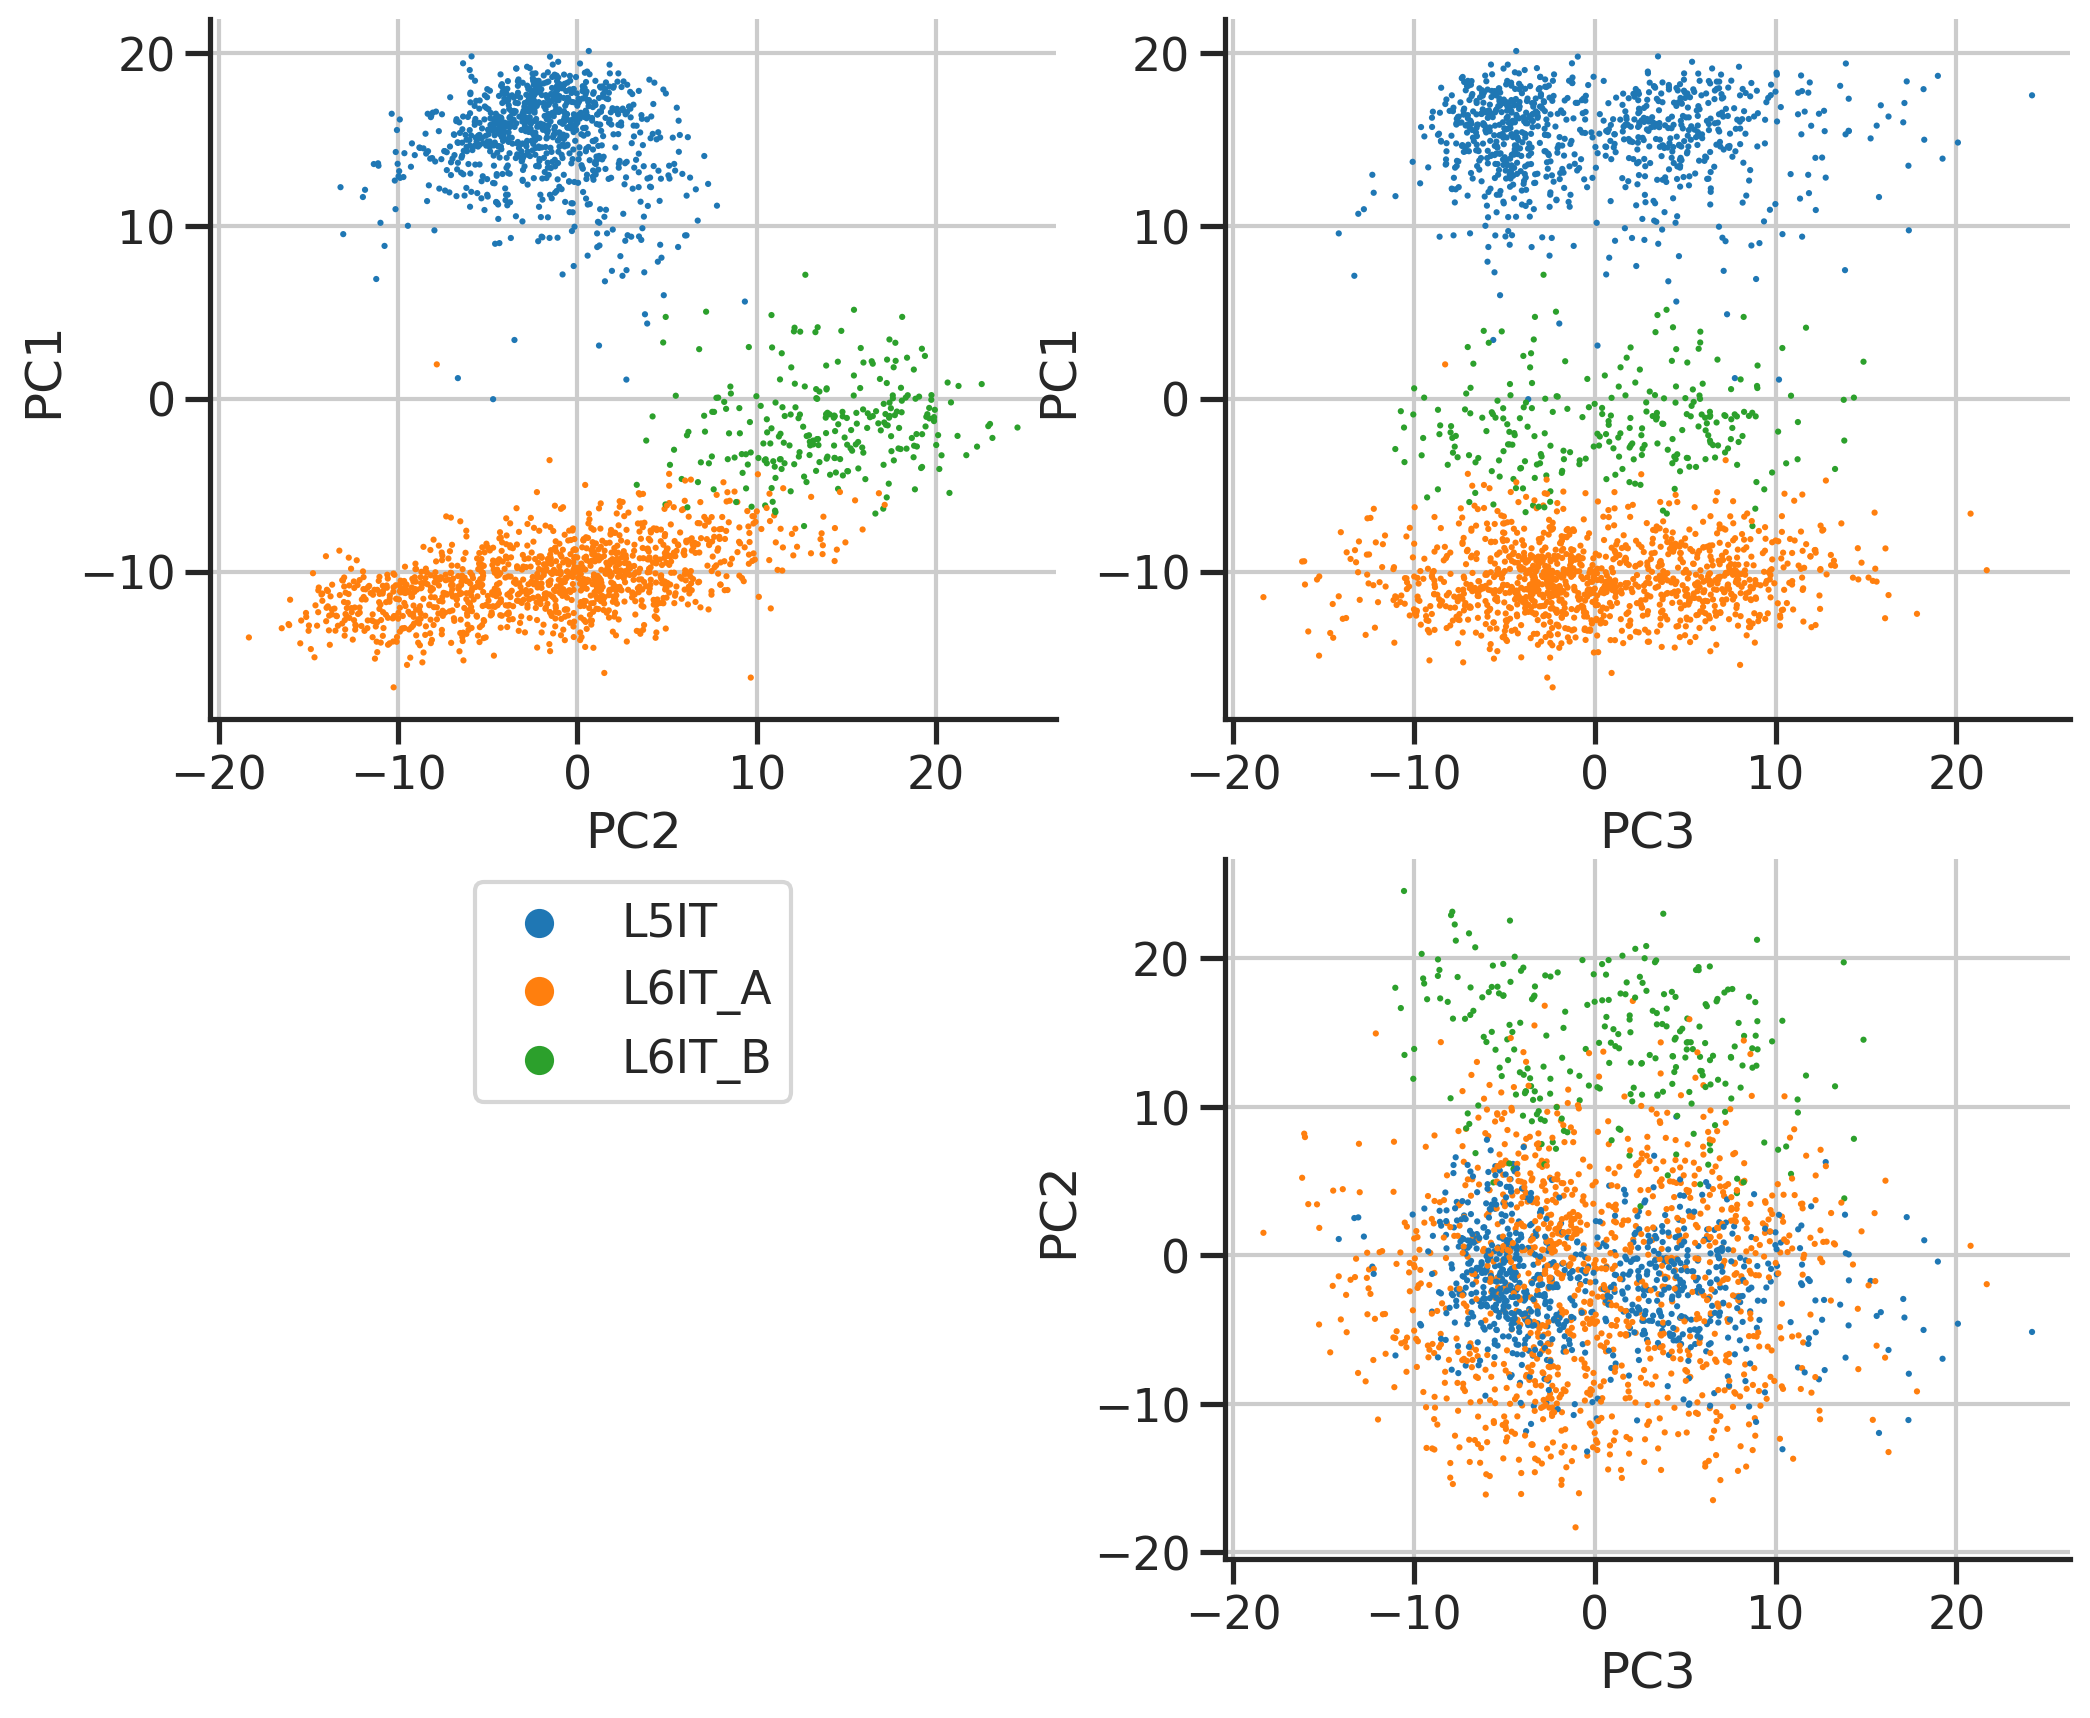

In [27]:
plot_pcs(res, 3, 'type') #, palette=palette_type_abc)

# DR

In [28]:
res = res_dr

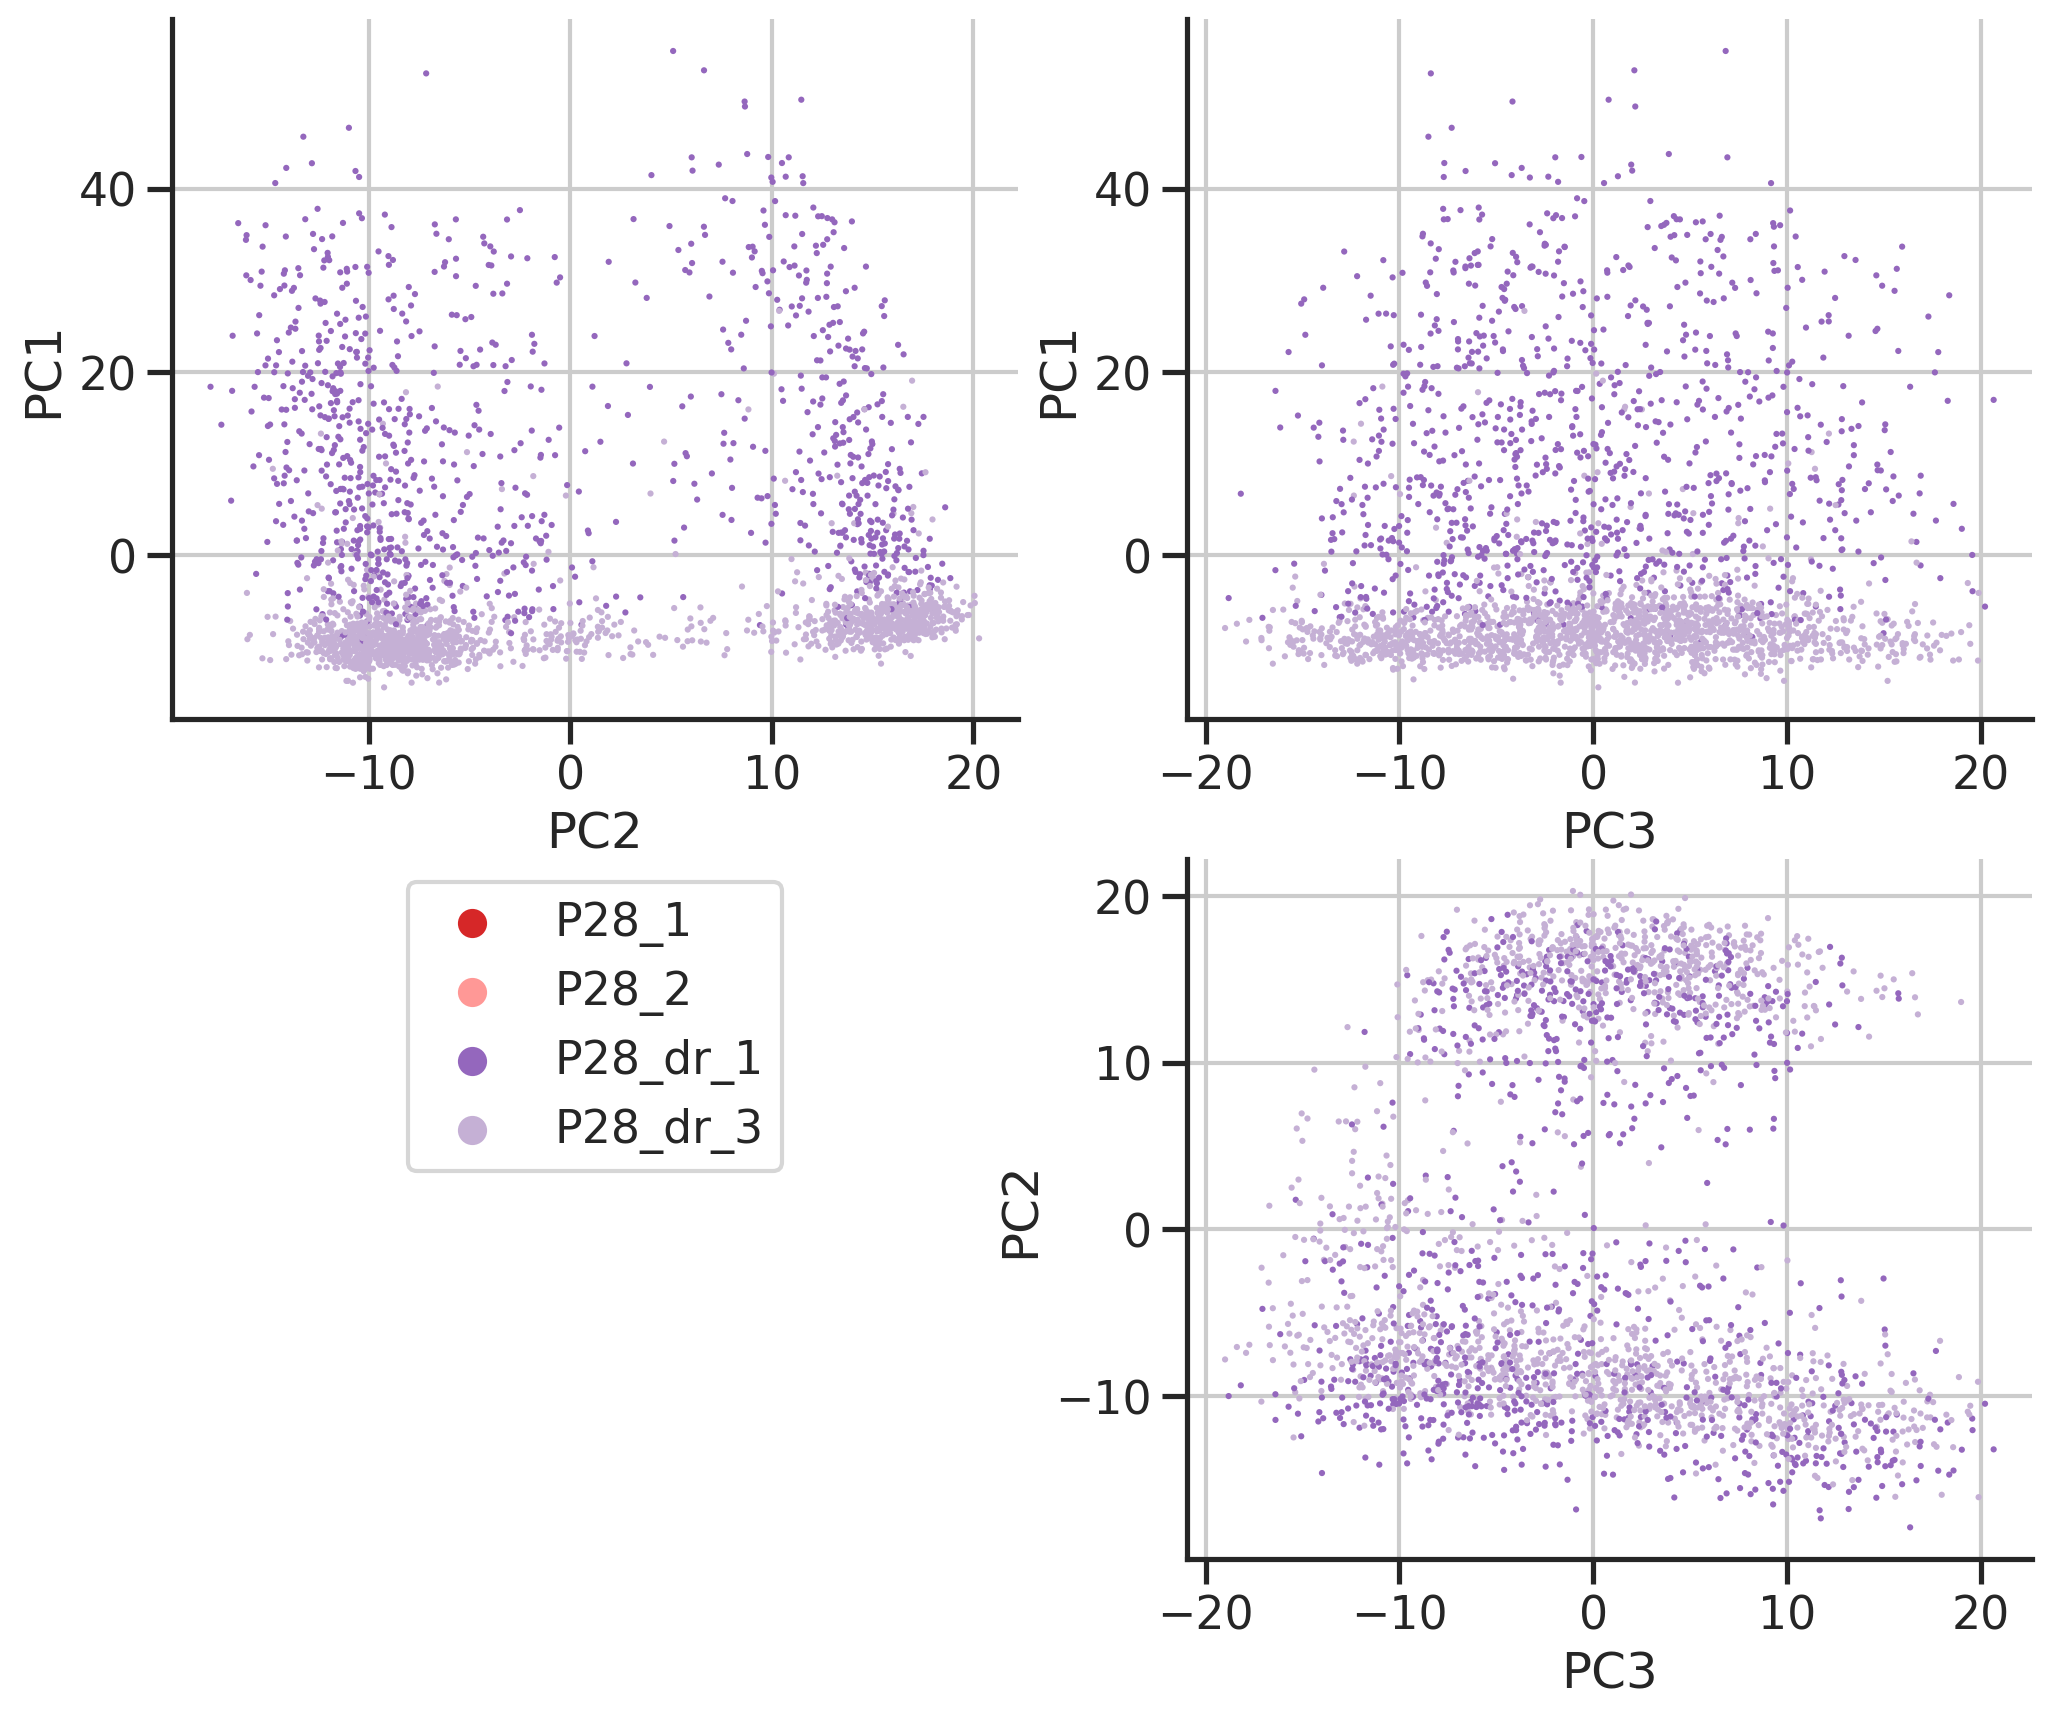

In [29]:
plot_pcs(res, 3, 'biosamp', palette=palette_biosamp)

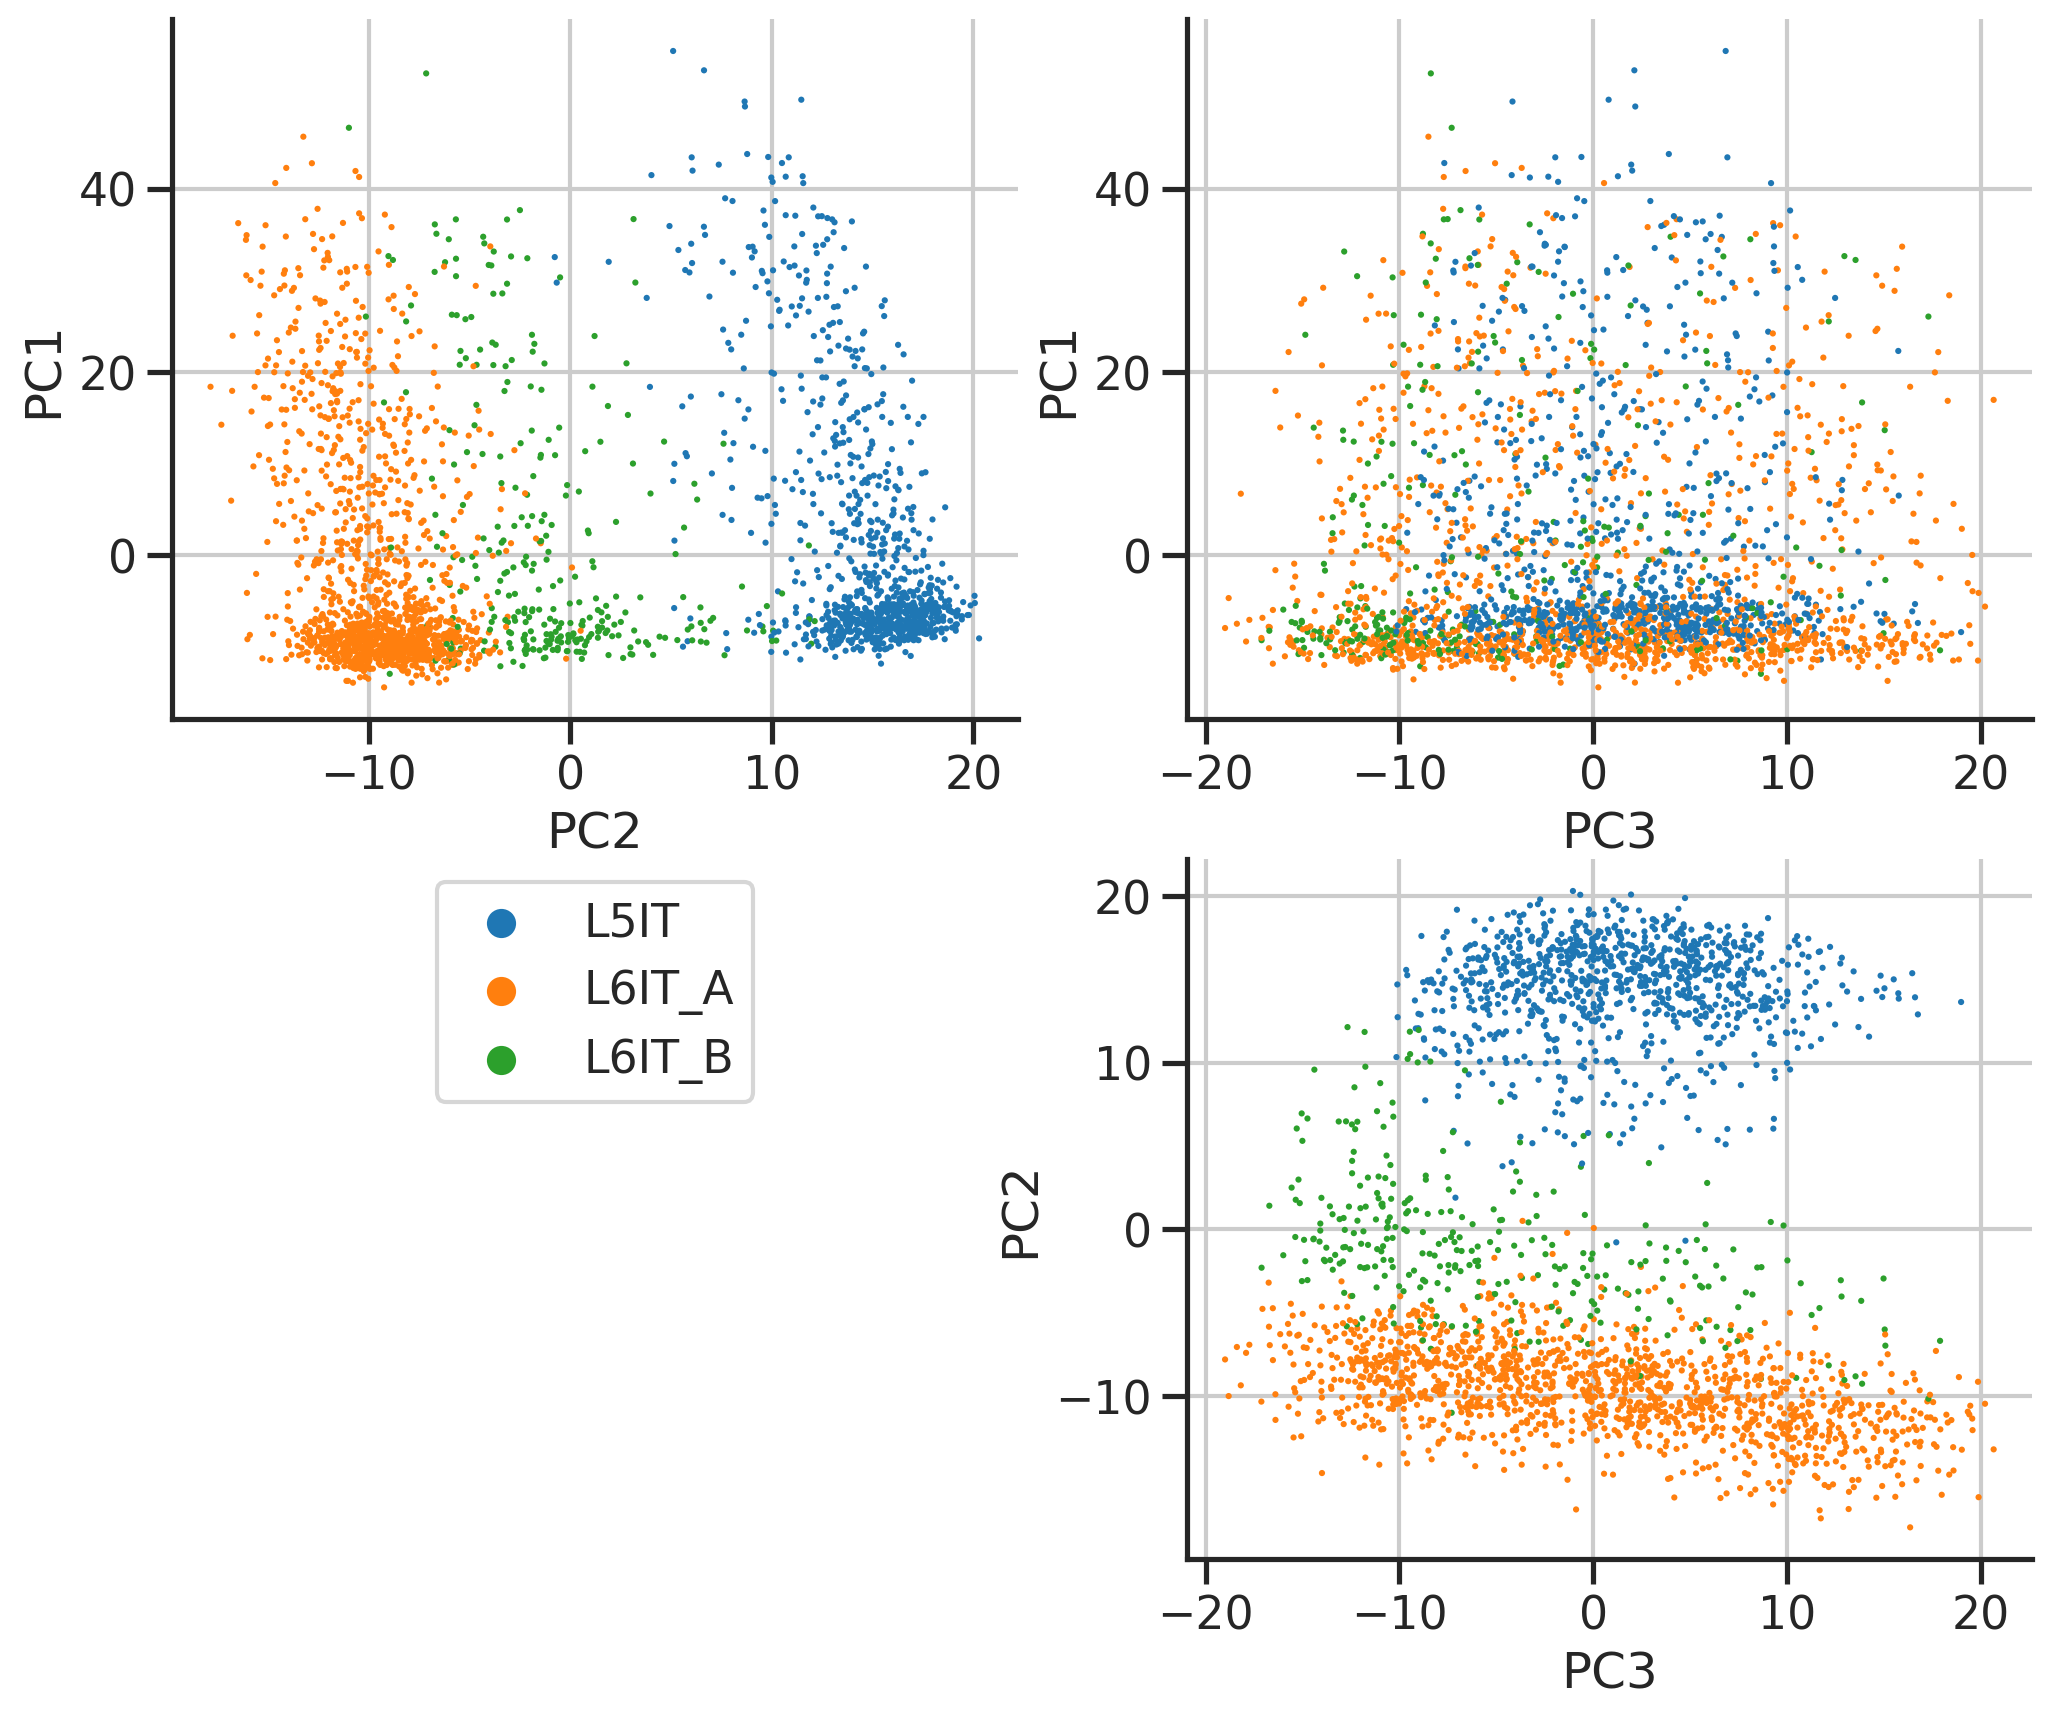

In [30]:
plot_pcs(res, 3, 'type') #, palette=palette_type_abc)